In [1]:
%matplotlib inline
from pylab import *

In [2]:
λ0 = 2.
λ1 = 20.
α0 = .2
α1 = 2.
μ  = 5.

def MMPPM1(x0 = (0,0),Tmax=200):
    ######################################
    # supply the rates r0 and r1 in the code below
    # r0 is the rate of exit from state (0,0)
    # r0 is the rate of exit from state (0,1)
    global r0,r1
    r0 = λ0 + α0
    r1 = λ1 + α1
    ######################################
    T        = [0]  # list of instants of events 
                    # (arrivals,departures, change of phase)
    X        = [x0] # initial state of the system, list of state evolutions
    while T[-1]<Tmax:
        n,ph  = X[-1]
        # Probabilities to move up/down/left/right in the transition diagram:
        # given by Pu/Pd/Pl/Pr
        if ph==0: 
            Pu = 0
            if n==0: 
                rate     = r0  # rate of events
                Pl,Pd,Pr = 0,α0/rate,λ0/rate
            else:
                rate     = r0+μ
                Pl,Pd,Pr = μ/rate,α0/rate,λ0/rate
        else: #(ph==1)
            Pd = 0
            if n==0: 
                rate     = r1
                Pl,Pu,Pr = 0,α1/rate,λ1/rate
            else:
                rate     = r1+μ
                Pl,Pu,Pr = μ/rate,α1/rate,λ1/rate
            
        # generating the date of a new event
        T   = T + [T[-1]+(-1./rate)*log(rand(1))]
        # generating move
        x   = rand(1)
        if   x<Pu:             ph-=1  # move up
        elif Pu<x<Pu+Pd:       ph+=1  # move down
        elif Pu+Pd<x<Pu+Pd+Pl: n-=1  # move left
        else:                  n+=1  # move right
        X   = X +[(n,ph)]

    T    = array(T[:-1],dtype=object) # event after Tmax is discarded
    X    = array(X[:-1],dtype=object)
    return T,X

#-------------
MMPPM1(x0 = (0,0),Tmax=200)
V1,V2 = r0, r1

Text(0, 0.5, 'number of clients')

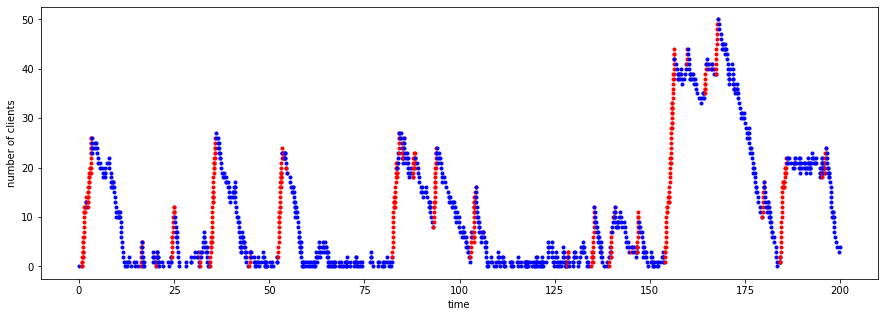

In [3]:
T,X = MMPPM1()

rcParams['figure.figsize'] = 15, 5
for index,t in enumerate(T):
    if X[index][1] == 0:
        plot(t,X[index][0],'b.')
    else:
        plot(t,X[index][0],'r.')
xlabel('time')
ylabel('number of clients')

In [4]:
T,X = MMPPM1(Tmax=10**4)

P_est = sum((T[1:]-T[:-1])*(X[:-1][:,1]==1))/T[-1]


In [5]:
###########
# supply the mean rate of arrivals in the MMPP/M/1
λm    = (α1 * λ0 + α0 * λ1) / (α0 + α1)
###########

###########
# supply the mean sojourn time for the M/M/1 with arrival rate λm
rho = λm / μ
R_MM1 = 1 / (μ * (1 - rho)) 
###########

#---
V3,V4 = λm, R_MM1
V3,V4

(3.6363636363636362, 0.7333333333333334)

In [6]:
def MMPPM1_v2(x0=(0,0),Tmax=200):
    r0 = α0+λ0 # rate of exit from state (0,0)
    r1 = α1+λ1 # rate of exit from state (0,1)
    T  = [0]   # list of instants of events 
               # (arrivals,departures, change of phase)
    X  = [x0]  # initial state of the system, 
               # list of state evolutions
    arrival_times = [-1 for k in range(x0[0])]  # arrival times 
    # of clients in the system; Sojourn times of clients present at t=0 
    # in the system will not be evaluated.
    # Their arrival times are arbitrarily set to -1.
    D  = []    # delays: times spent by users inside the system
    while T[-1]<Tmax:
        n,ph  = X[-1]
        # Probabilities to move up/down/left/right in the transition diagram:
        # given by Pu/Pd/Pl/Pr
        if ph==0: 
            Pu = 0
            if n==0: 
                rate     = r0  # rate of events
                Pl,Pd,Pr = 0,α0/rate,λ0/rate
            else:
                rate     = r0+μ
                Pl,Pd,Pr = μ/rate,α0/rate,λ0/rate
        else: #(ph==1)
            Pd = 0
            if n==0: 
                rate     = r1
                Pl,Pu,Pr = 0,α1/rate,λ1/rate
            else:
                rate     = r1+μ
                Pl,Pu,Pr = μ/rate,α1/rate,λ1/rate
            
        # generating the date of a new change of state
        T     = T + [T[-1]+(-1./rate)*log(rand(1))]
        # generating move
        x     = rand(1)
        entry = 0 # type of change (+1:arrival, -1: departure, 0: change of phase)
        if   x<Pu:             ph-=1  # move up
        elif Pu<x<Pu+Pd:       ph+=1  # move down
        elif Pu+Pd<x<Pu+Pd+Pl:        # move left
            n    -= 1  
            entry = -1                # departure
        else:                         # move right
            n    += 1  
            entry = 1                 # arrival
        X   = X +[(n,ph)]
        #-------- New part of the code ----------------------
        #  (see also part 2 of lab 1)
        if entry == 1: # arrival
            # the time of entering client is recorded in 
            # the arrival_times FIFO (First In - First Out) stack:
            arrival_times.append(T[-1])
        elif entry == -1: # departure
            # arrival time T_in of the client going out of the system.
            # T_in is extracted from the arrival_times FIFO stack:
            T_in = arrival_times.pop(0)
            ############################################
            # if the client entered the system after t=0
            # (T_in>0), we add the time he spent in the sytem 
            # to delays list 
            if T_in>0:
                D.append(T[-1] - T_in)
            ############################################
        #-----------------------------------------------------
        
    T    = array(T[:-1],dtype=object) # event after Tmax is discarded
    X    = array(X[:-1],dtype=object)   
    return T,X,D

In [7]:
T,X,D = MMPPM1_v2(Tmax=200)

In [8]:
import IPython.core.display as disp

disp.display_latex(r'Mean delay for $M/M/1$ with arrivals at rate '
                +r'$\overline{\lambda}=1/(\mu-\overline{\lambda})$'
                +'={0:.2f}'.format(R_MM1),raw=True)
####################
# Supply the estimated value for the mean sojourn time
# in the MMPP/M/1
R_MMMPPM1 = mean(D)
####################
disp.display_latex('Mean delay for $MMPP/M/1$ = {0:.3f}'
                   .format(R_MMMPPM1),raw=True)
#----
V5 = R_MMMPPM1

In [9]:
print("---------------------------------------------------\n"
      +"VALIDITY OF RESULTS SUPPLIED FOR WEEK IV - Part II:\n"
      +"---------------------------------------------------")
results  = dict()
for k in range(1,6):
    results["V"+str(k)] = "NO"
    
try: 
    if abs(V1-2.2)<.0001:  results["V1"] =  "OK"
except: pass
try: 
    if abs(V2-22.)<.0001:  results["V2"] =  "OK"
except: pass
try: 
    if abs(V3-3.636)<.001: results["V3"] =  "OK"
except: pass
try: 
    if abs(V4-.733)<.001:  results["V4"] =  "OK"
except: pass
try: 
    if V5>1:               results["V5"] =  "OK"
except: pass

for key,val in results.items():
    print(key,': ',val)

---------------------------------------------------
VALIDITY OF RESULTS SUPPLIED FOR WEEK IV - Part II:
---------------------------------------------------
V1 :  OK
V2 :  OK
V3 :  OK
V4 :  OK
V5 :  OK
